In [42]:
import os
import time
import random
import math
import sys

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFilter
from skimage.measure import regionprops

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

sys.path.append("../")
import resnet

# change these to point to data in a numpy file and the metadata csv
test_data_path = 'example_data/test_subset.npy'
test_csv_path = 'example_data/test.csv'

test_data = np.load(test_data_path)[:300]
test_csv = pd.read_csv(test_csv_path)

# change this to the path of a pytorch model saved using `torch.save()`
model_path = 'example_data/chipnet_weights.pt'

model = torch.load(model_path)
model.eval()

# change this to the directory containing the original (square cropped) images
full_sz_path = ''

%matplotlib inline 

C:\Users\chris\anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'resnet.ChipNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [43]:
no_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
]) 

In [44]:
def get_square_bbox(bb):
    # this function takes a bounding box of the form:
    # [y1, x1, y2, x2] and converts it to a square bounding box with the
    # same center with a side length matching the long side of the original bb

    # compute change in x and change in y (side lengths)
    diffs = (bb[3] - bb[1], bb[2] - bb[0])

    # determine the center of the input bounding box
    center = (bb[1] + (diffs[0] // 2), bb[0] + (diffs[1] // 2))

    # determine the length of the long side
    short_len = max(*diffs)

    # divide shot side by two to determine how far the to move from center
    half_short_len = short_len // 2

    # return a square bounding box by offsetting from the center of the bb
    # make sure to not go past 0 or 224 to stay in the image
    return [
        np.clip(center[0] - half_short_len, 0, 224), 
        np.clip(center[1] - half_short_len, 0, 224), 
        np.clip(center[0] + half_short_len, 0, 224), 
        np.clip(center[1] + half_short_len, 0, 224)
    ]

model output: 0.006144832819700241


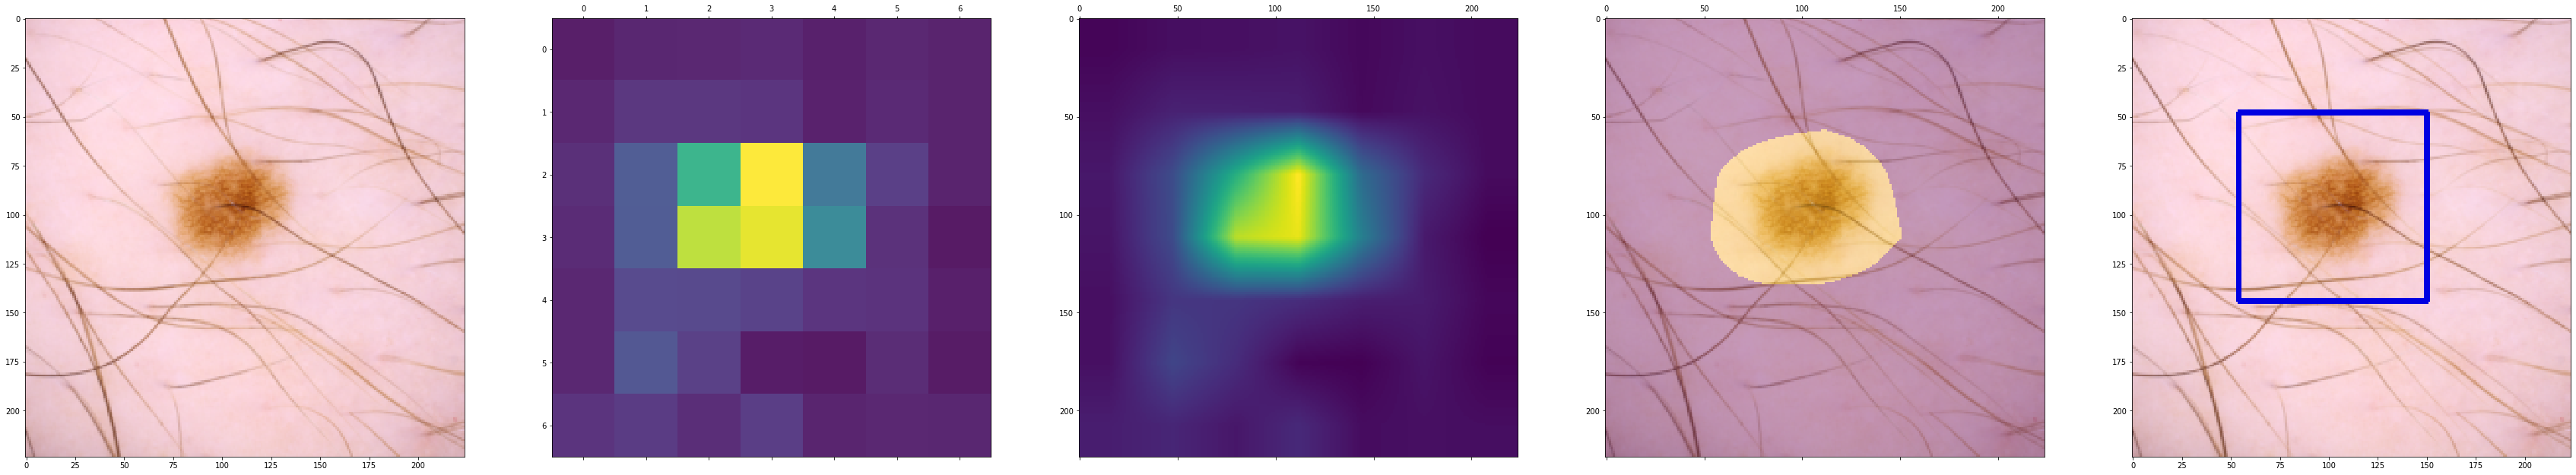

In [47]:
num_devs = 1.

# grab a random image from the test data array
idx = random.randint(0, len(test_data))
test_img = Image.fromarray(test_data[idx])
hw = float(test_img.size[0])

# save a copy of the image so that we don't overwrite it
np_img = test_data[idx].copy()
orig_img = test_img.copy()

# normalize the image to send through the model
test_img = no_transform(test_img)
test_img = test_img.cuda()

# run the chipping operation using unfold
chips = test_img.data.unfold(0, 3, 3).unfold(1, 32, 32).unfold(2, 32, 32)[0]
chips = chips.reshape(-1, 3, 32, 32)

# run the cips through the model to get the attention maps
output = model(chips.unsqueeze(0), _)

print(f"model output: {torch.sigmoid(output).item()}")

# the attention map is stored in the model after the forward pass
attn_map = model.attn_map[0]

# use bilinear upscaling on the attention map to match input size
upscaled = cv2.resize(attn_map.view(7, 7).detach().cpu().numpy(), (224, 224), interpolation=cv2.INTER_LINEAR)

# use statistical threshold to generate a binary mask
binary = (upscaled > (upscaled.mean() + upscaled.std() * num_devs)).astype(np.uint8)

# convert the binary mask to a bounding box that encapsulates it
props = regionprops(binary)
prop = props[0]

# conver the bounding box into a square bounding box
sqr_bb = get_square_bbox(prop.bbox)
cv2.rectangle(np_img, (sqr_bb[0], sqr_bb[1]), (sqr_bb[2], sqr_bb[3]), (0, 0, 225), 2)

# if we have the original image path we can cross-reference it to get a 
# higher resolution version of the crop generated by the attention
if full_sz_path != '':
    
    # load the full size image 
    img_name = test_csv.iloc[idx]['image_name']
    full_sz = Image.open(f'{full_sz_path}{img_name}.jpg')
    full_hw = float(full_sz.size[0])

    # adjust the small iamge bounding box to encapsulate the same
    # are on the original resolution image
    adj_bb = [pt * (full_hw / hw) for pt in sqr_bb]
    
    # crop the high res image using the adjusted bounding box
    cropped = transforms.functional.crop(
        full_sz, 
        adj_bb[1], 
        adj_bb[0], 
        adj_bb[2] - adj_bb[0], 
        adj_bb[3] - adj_bb[1]
    )
    
    # resize the crop to 224 x 224 
    cropped = transforms.functional.resize(cropped, 224, interpolation=5)
    
    # for comparison crop the small image to see the granularity
    # that is gained from cropping the original images
    scaled_crop = transforms.functional.crop(
        orig_img, 
        sqr_bb[1], 
        sqr_bb[0], 
        sqr_bb[2] - sqr_bb[0], 
        sqr_bb[3] - sqr_bb[1], 
    )
    
    # resize the low resolution crop to 224 x 224
    scaled_crop = transforms.functional.resize(scaled_crop, 224, interpolation=2)

    print(f'mulitplier: {(full_hw / hw)}')

    fig, axes = plt.subplots(1, 6, figsize=(60, 30))
    
    # display the various stages of the cropping process
    axes[0].imshow(orig_img)
    axes[1].matshow(model.attn_map[0].view(7, 7).detach().cpu().numpy(), alpha=0.9)
    axes[2].imshow(orig_img)
    axes[2].matshow(binary.reshape(224, 224), alpha=0.3)
    axes[3].imshow(np_img)
    axes[4].imshow(scaled_crop, interpolation='none')
    axes[3].imshow(cropped, interpolation='none')
    
else:
    fig, axes = plt.subplots(1, 5, figsize=(60, 30))
    
    axes[0].imshow(orig_img)
    axes[1].matshow(model.attn_map[0].view(7, 7).detach().cpu().numpy(), alpha=0.9)
    axes[2].matshow(upscaled.reshape(224, 224))
    axes[3].imshow(orig_img)
    axes[3].matshow(binary.reshape(224, 224), alpha=0.3)
    axes[4].imshow(np_img)

